<a href="https://colab.research.google.com/github/frankbass3/Graph-Neural-Networks/blob/main/GCNN_application_citeseer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Application of Graph Convolutional Network to a document citation graph

In this notebook we will see an implementation of a GCN architecture in tensorflow. 

The model will be applied on a classification task, described by predicting the topic of scientific papers, given their received and provided citations. 

The dataset is the Cora Dataset (downloadable [here](https://github.com/tkipf/pygcn/tree/master/data/cora)), consisting in about 2.7k scientific publications linked by about their citations. Each document is classified into one of 7 classes and its corpus is described by a Bag of Words vector.

## Setup and package import

Note that we are using Tensorflow 2.0

In [ ]:
from networkx import (
    spring_layout, draw_networkx_nodes, draw_networkx_edges, draw_networkx_labels,
    set_node_attributes,
    write_edgelist,
    to_numpy_matrix
)
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import imageio
import sys
import pickle as pkl
import scipy.sparse as sp
from scipy.sparse.linalg.eigen.arpack import eigsh

%tensorflow_version 2.x
import tensorflow as tf



TensorFlow 2.x selected.


## Import of the Cora dataset data

The dataset is described by 2 files that must be uploaded to the Colab environment. Hence, we will firstly create a folder and upload those using the file explorer of Colab on the left.

After uploading, we simply load data with pandas.

In [ ]:
cora_edges_df = pd.read_csv('./cora/cora.cites', sep='\t', header=None)
cora_nodes_df = pd.read_csv('./cora/cora.content', sep='\t', header=None)

print(cora_edges_df)
print(cora_nodes_df)

           0        1
0         35     1033
1         35   103482
2         35   103515
3         35  1050679
4         35  1103960
...      ...      ...
5424  853116    19621
5425  853116   853155
5426  853118  1140289
5427  853155   853118
5428  954315  1155073

[5429 rows x 2 columns]
         0     1     2     3     ...  1431  1432  1433                    1434
0       31336     0     0     0  ...     0     0     0         Neural_Networks
1     1061127     0     0     0  ...     0     0     0           Rule_Learning
2     1106406     0     0     0  ...     0     0     0  Reinforcement_Learning
3       13195     0     0     0  ...     0     0     0  Reinforcement_Learning
4       37879     0     0     0  ...     0     0     0   Probabilistic_Methods
...       ...   ...   ...   ...  ...   ...   ...   ...                     ...
2703  1128975     0     0     0  ...     0     0     0      Genetic_Algorithms
2704  1128977     0     0     0  ...     0     0     0      Genetic_Algorithms


Then let's extract nodes ids, edges and features into arrays from the two dataframes.

In [ ]:
# nodes, nodes_features and edges
nodes_features = cora_nodes_df[list(range(1,1434))].to_numpy(dtype='float32')
edge_sources = cora_edges_df[0].to_numpy()
edge_destinations = cora_edges_df[1].to_numpy()
nodes = cora_nodes_df[0].to_numpy()
edges = list(zip(edge_sources, edge_destinations))

In [ ]:
# labels
labels = cora_nodes_df[1434].to_numpy()
all_labels = list(set(labels))
labels_as_int = cora_nodes_df[1434].apply(lambda x : all_labels.index(x)).to_numpy() # this is useful for plotting purposes
labels_one_hot = pd.get_dummies(cora_nodes_df[1434]).to_numpy().tolist()

Let's just check the lists that we have created

In [ ]:
print("Shape of nodes: %s" % str(nodes.shape))
print("Shape of labels: %s" % str(labels.shape))
print("Shape of labels_one_hot: (%i, %i)" % (len(labels_one_hot), len(labels_one_hot[0])))
print("Contents of all_labels: %s" % str(all_labels))

Shape of nodes: (2708,)
Shape of labels: (2708,)
Shape of labels_one_hot: (2708, 7)
Contents of all_labels: ['Genetic_Algorithms', 'Neural_Networks', 'Reinforcement_Learning', 'Probabilistic_Methods', 'Theory', 'Rule_Learning', 'Case_Based']


## Build of a Networkx DiGraph

Here we are going to create a networkx directed graph out of the data that we have just loaded. This will help us in generating additional information regarding the graph later.

In [ ]:
input_graph=nx.DiGraph()
input_graph.add_nodes_from(nodes)
input_graph.add_edges_from(edges)

Let's see some numbers about our graph

In [ ]:
print("Number of nodes: %i" % len(nodes))
print("Number of edges: %i" % len(edge_sources))
print("Number of source nodes: %i" % len(set(edge_sources)))
print("Number of destination nodes: %i" % len(set(edge_destinations)))
print("Number of linked nodes: %i" % len(set(edge_sources).union(set(edge_destinations))))
print("Number of nodes features: %i" % nodes_features.shape[1])

Number of nodes: 2708
Number of edges: 5429
Number of source nodes: 1565
Number of destination nodes: 2222
Number of linked nodes: 2708
Number of nodes features: 1433


Everything seems just fine until here.

# Plot of the graph
This is not such a big graph, yet it is already enough big to make it practically not understandable with one screen-size picture. 

Anyway, let's proceed with the plot just to have an overview of our dataset as a whole.

In [ ]:
# computation of nodes positions: this might take one minute
graph_pos = spring_layout(input_graph, k=.001, iterations=500)

(-1.1847603914141653,
 1.207601666152477,
 -1.1909222614765167,
 1.1898646366596222)

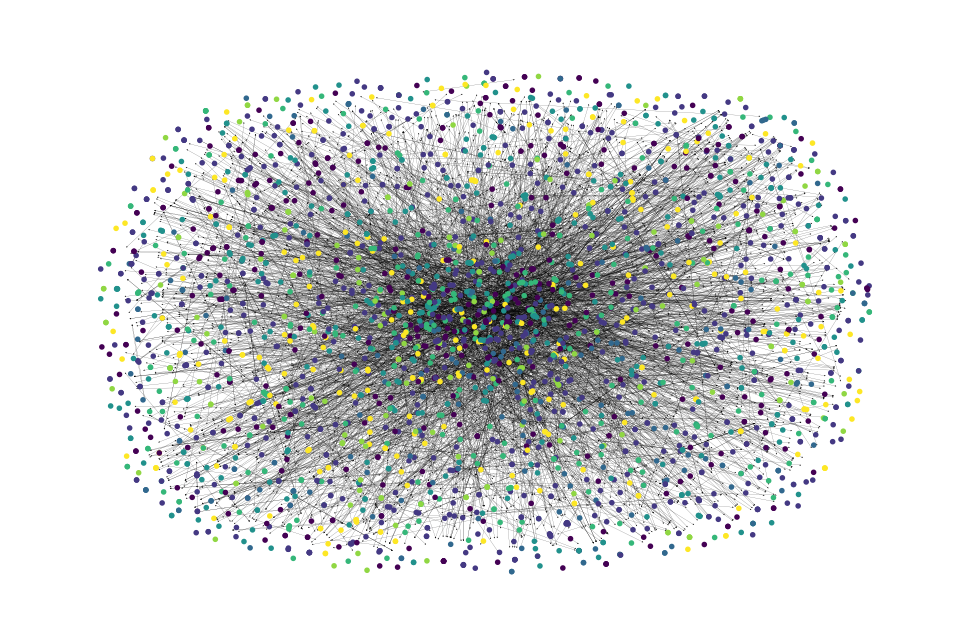

In [ ]:
# graph plot
plt.figure(dpi=200)
draw_networkx_nodes(input_graph, graph_pos, node_size=1, node_color=labels_as_int)
draw_networkx_edges(input_graph, graph_pos, width=.05, arrowsize=1)
plt.axis('off')

# Dataset split

Before implementing the model, let's care about making a reasonable split of the dataset into training and test. 

Firstly, we split the node list in standard proportion 70/30. After this we create two binary vectors that will be multiplied with the results from the loss function: in this way we will set to 0 the error associated to nodes in the training/test set w.r.t. the case.

In [ ]:
shuffle_index = list(range(len(nodes)))
np.random.shuffle(shuffle_index)
split_index = int(len(shuffle_index) * .7)

train_nodes = nodes[shuffle_index[:split_index]]
train_labels = labels[shuffle_index[:split_index]]
test_nodes = nodes[shuffle_index[split_index:]]
test_labels = labels[shuffle_index[split_index:]]

# we will use this vector with the actual loss function to only consider loss values of nodes in the train set
train_loss_multiplier = np.array([1 if node in train_nodes else 0 for node in nodes])
test_loss_multiplier = np.array([1 if node not in train_nodes else 0 for node in nodes])

print("Number of train nodes: %i" % len(train_nodes))
print("Number of test nodes: %i" % len(test_nodes))

Number of train nodes: 1895
Number of test nodes: 813


In [ ]:
# adjacency matrix
train_adjacency = to_numpy_matrix(input_graph, nodelist=nodes)

# identity matrix
train_identity = np.eye(input_graph.number_of_nodes())

# A_hat = A + I
train_A_hat = train_adjacency + train_identity

# degree matrix
train_D_hat = np.array(np.sum(train_A_hat, axis=0))[0]
train_D_hat = np.matrix(np.diag(train_D_hat))
# normalized Laplacian of the graph
inv_train_D_hat = train_D_hat**-1
inv_train_D_hat = np.sqrt(inv_train_D_hat)
inv_D_mult_A = tf.matmul(tf.matmul(inv_train_D_hat, train_A_hat),inv_train_D_hat)

Some numbers about the matrix only to check that everything is fine: these prints must be all equal.

In [ ]:
print(train_identity.shape)
print(train_A_hat.shape)
print(train_D_hat.shape)
print(inv_train_D_hat.shape)

(2708, 2708)
(2708, 2708)
(2708, 2708)
(2708, 2708)


## Build of GCN Model

To develop our GCN Model, we use the tensorflow framework:

- we build a GCN_layer class that extends the Keras layer and computes the convolution operation with the graph Laplacian.

- we build a GCN_Model class extending the keras Model and implementing the whole neural networks. It is composed by a first stack of GCN_layers that computes the nodes embeddings, followed by a stack of Keras Dense layers to perform the classification task.

The GCN_model class can be initialized with two lists of int, to specify the number and dimensions of both GCN and Dense layers wanted. For this particular problem, we will create an architecture of:

- 2 GCN layers: [64,48]
- 2 Dense layers: [48, len(all_labels)]

In [ ]:
class GCN_layer(tf.keras.layers.Layer):
    num_outputs = None
    weights = None
    activation = None

    def __init__(self, input_shape, num_outputs, initializer='glorot_normal', activation=tf.nn.relu):
      super(GCN_layer, self).__init__()
      self.num_outputs = num_outputs
      self.activation = activation
      self.weights = self.add_weight(initializer=initializer,
                                     regularizer=tf.keras.regularizers.l2(l=.05),
                                     shape=[int(input_shape[-1]),
                                            self.num_outputs])

    def call(self, inputs):
      inv_D_mult_A, _input = inputs
      # computes (inv_D_mult_A * X * W)
      return self.activation(tf.matmul(tf.matmul(inv_D_mult_A, _input), self.weights))

In [ ]:
class GCN_model(tf.keras.Model):
    n_layers = None
    all_weights = None
    __gcn_layers = None
    __fc_layers = None

    def __init__(self, input_shape, gcn_layers_dimensions, fc_layers_dimensions):
        super(GCN_model, self).__init__(name='GCN mapping model')
        
        self.all_weights = []
        self.__gcn_layers = []
        self.__fc_layers = []
        self.n_layers = len(gcn_layers_dimensions)
        
        # add gcn layers
        self.__gcn_layers.append(GCN_layer(input_shape, gcn_layers_dimensions[0]))
        self.all_weights.append(self.__gcn_layers[-1].weights)
        for i in range(1,len(gcn_layers_dimensions)):
          self.__gcn_layers.append(GCN_layer((None,gcn_layers_dimensions[i-1]), gcn_layers_dimensions[i]))
          self.all_weights.append(self.__gcn_layers[-1].weights)

        # add dense layers
        self.__fc_layers.append(tf.keras.layers.Dense(fc_layers_dimensions[0], 
                            kernel_initializer=tf.keras.initializers.he_normal(),
                            kernel_regularizer=tf.keras.regularizers.l2(l=.05),
                            activation='sigmoid', input_shape=(gcn_layers_dimensions[-1],)))
        self.__fc_layers[-1].build(input_shape=(gcn_layers_dimensions[-1],))
        self.all_weights.append(self.__fc_layers[-1].kernel)
        self.all_weights.append(self.__fc_layers[-1].bias)
        for i in range(1,len(fc_layers_dimensions)):
            self.__fc_layers.append(tf.keras.layers.Dense(fc_layers_dimensions[i], 
                            kernel_initializer=tf.keras.initializers.he_normal(),
                            activation='softmax', input_shape=(fc_layers_dimensions[i-1],)))
            self.__fc_layers[-1].build(input_shape=(fc_layers_dimensions[i-1],))
            self.all_weights.append(self.__fc_layers[-1].kernel)
            self.all_weights.append(self.__fc_layers[-1].bias)

    def call(self, inputs):
        inv_D_mult_A, _input = inputs
        output = _input
        for layer in self.__gcn_layers:
            output = layer((inv_D_mult_A, output))
        for layer in self.__fc_layers:
            output = layer(output)
        return output

    def get_node_embedding(self, inputs):
        inv_D_mult_A, _input = inputs
        output = _input
        for layer in self.__gcn_layers:
            output = layer((inv_D_mult_A, output))
        return output


Let's create just an example here:

In [ ]:
gcn_model_example = GCN_model(nodes_features.shape, [64,48],[48, len(all_labels)])

In [ ]:
# calling the model returns results from the final layer, i.e. the classification scores
gcn_model_example([inv_D_mult_A, nodes_features])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(2708, 7), dtype=float32, numpy=
array([[0.12174504, 0.07044578, 0.17678387, ..., 0.06918824, 0.17908485,
        0.17055026],
       [0.12167919, 0.06996074, 0.17660123, ..., 0.06831649, 0.18064427,
        0.17006144],
       [0.12224208, 0.06971769, 0.173684  , ..., 0.06884366, 0.1792552 ,
        0.17259336],
       ...,
       [0.12227292, 0.0696914 , 0.17401849, ..., 0.06873868, 0.1794236 ,
        0.17228325],
       [0.10832428, 0.06651707, 0.20605354, ..., 0.05869779, 0.20732872,
        0.15717724],
       [0.11313345, 0.06461823, 0.18778996, ..., 0.06074204, 0.19344969,
        0.15681042]], dtype=float32)>

In [ ]:
# calling the get_node_embedding returns the embedding associated by the final GCN_layer to the nodes
gcn_model_example.get_node_embedding([inv_D_mult_A, nodes_features])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(2708, 48), dtype=float32, numpy=
array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        3.8960822e-02, 0.0000000e+00],
       [5.7634315e-03, 0.0000000e+00, 4.3627594e-02, ..., 0.0000000e+00,
        0.0000000e+00, 2.0108323e-03],
       [5.1320693e-03, 0.0000000e+00, 1.6963807e-03, ..., 2.1195700e-04,
        3.4297782e-04, 0.0000000e+00],
       ...,
       [4.9486202e-03, 0.0000000e+00, 4.4765007e-03, ..., 0.0000000e+00,
        0.0000000e+00, 2.6946974e-03],
       [4.7509578e-01, 0.0000000e+00, 4.7470722e-01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.9312775e-01, 0.0000000e+00, 5.0464056e-02, ..., 0.0000000e+00,
        2.6123664e-01, 0.0000000e+00]], dtype=float32)>

Now let's train the model:

- we run the training for 10000 epochs.
- to keep the code simpler, we run every epoch with the whole training set and not dividing it in batches. The training is successfull as well, but always mind that splitting it in batches usually improves performances and training time.
- To not consider the test nodes during training, we will multiply the loss values by the train_loss_multiplier vector.

In [ ]:
# global variables for training
n_epochs = 10000
packed_inputs = [inv_D_mult_A, nodes_features]

# init the model
gcn_model = GCN_model(nodes_features.shape, [64,48],[48, len(all_labels)])

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate=.0002)
for epoch in range(n_epochs):
    with tf.GradientTape() as tape:
        prediction = gcn_model(packed_inputs)
        loss = tf.losses.categorical_crossentropy(labels_one_hot,
                                                  prediction) 
        
        train_loss = loss * train_loss_multiplier
        test_loss = loss * test_loss_multiplier
        gradients = tape.gradient(train_loss, gcn_model.all_weights)
        optimizer.apply_gradients(zip(gradients, gcn_model.all_weights))
        if epoch % 10 == 0:
            print("train_loss:", tf.reduce_sum(train_loss).numpy()/len(train_nodes))
            print("test_loss:", tf.reduce_sum(test_loss).numpy()/(len(nodes)-len(train_nodes)))
            
##############
# best performances:
# train_loss: 0.14010808537062994
# test_loss: 0.6986547941651291


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

train_loss: 2.144288526550132
test_loss: 2.1690298458160364
train_loss: 2.0879693426368733
test_loss: 2.1147776248270294
train_loss: 2.0368697435686016
test_loss: 2.0649341991466788
train_loss: 1.9879647046091689
test_loss: 2.0171192727552274
train_loss: 1.940048209721306
test_loss: 1.9706691915551968
train_loss: 1.8930883080474934
test_loss: 1.9251799073166513
train_loss: 1.846576877885884
test_loss: 1.8804027749750154
train_loss: 1.8002985086164247
test_loss: 1.8357486138337946
train_loss: 1.754008544

KeyboardInterrupt: ignored

In [ ]:
predictions = gcn_model(packed_inputs)

accuracy = 0.
num_values = 0
for i in range(predictions.shape[0]):
    if test_loss_multiplier[i] == 1:
        pred_label = np.argmax(predictions[i].numpy())
        true_label = np.argmax(labels_one_hot[i])
        if pred_label == true_label:
          accuracy += 1.
        num_values+=1
accuracy/=num_values
print(accuracy)

0.7921279212792128


## Understanding of nodes embeddings
 
 To understand the effect of the training in the embeddings that are associated by the GCN layers to each node, we will use a technique for dimensionality reduction called T-SNE. 
 
 This technique allows us to reduce the dimensionality of node embeddings to 2 and then generate a plot. 

With this method, we will make and compare two plots:

- one of the embeddings generated by the example model, with random weights
- one of the embeddings generated by the trained model

In [ ]:
from sklearn.manifold import TSNE
colors = labels_as_int

embeddings_example = gcn_model_example.get_node_embedding(packed_inputs)
embeddings_train = gcn_model.get_node_embedding(packed_inputs)

X_embedded_example = TSNE(n_components=2).fit_transform(embeddings_example)
X_embedded_train = TSNE(n_components=2).fit_transform(embeddings_train)



In [ ]:
s=4

embedding_example = {node: np.array(X_embedded_example)[node] for node in range(len(X_embedded_example))}
x, y = zip(*[embedding_example[node] for node in embedding_example])
plt.scatter(x, y, c=colors, cmap='tab10', s=s)
plt.savefig(('./embedding_example.jpg').replace(' ','0'))
plt.clf()

embedding_train = {node: np.array(X_embedded_train)[node] for node in range(len(X_embedded_train))}
x, y = zip(*[embedding_train[node] for node in embedding_train])
plt.scatter(x, y, c=colors, cmap='tab10', s=s)
plt.savefig(('./embedding_train.jpg').replace(' ','0'))
plt.clf()

<Figure size 432x288 with 0 Axes>